In [ ]:
import os
from datasets import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)
import json
import einops
import pickle

In [2]:
model_name = "meta-llama/Llama-2-7b-hf"
model_suffix = model_name.split("/")[-1]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    device_map="auto")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map="auto", torch_dtype=torch.bfloat16)
model.eval()
device = model.device

model.lm_head = torch.nn.Identity()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
TOTAL_BATCHES = 100
batch_size = 32
final_matrix_path = os.getenv("FINAL_MATRIX_PATH", None)
final_matrix_path = "../output/test/final_matrix.pt"
final_weight = torch.load(final_matrix_path).cpu()



In [14]:
def filter_length(example):
    return len(tokenizer(example["text"])['input_ids']) >= 256

In [15]:
dataset = load_dataset("allenai/c4", "realnewslike", split="validation")
dataset = dataset.filter(filter_length)
dataset = dataset.shuffle(seed=42)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

In [34]:
output_path = "../output/k4_v1/output_delta1.7_gamma0.25.json"
import json
# Open the file as JSON
with open(output_path, 'r') as f:
    data = json.load(f)

samples = data["samples"]["full_model_text"]


In [35]:
final_weight = final_weight.to(device)

In [36]:
pbar = tqdm(total=TOTAL_BATCHES)
all_one_hots = []
for i in range(0, len(samples), batch_size):
    batch = samples[i:i + batch_size]
    with torch.no_grad():
        text = batch
        input_ids = tokenizer(text, padding=True, return_tensors="pt")["input_ids"]
        input_ids = input_ids.to(device)
        output = model(input_ids).logits[:, 1:]
        hidden_states = einops.rearrange(
            output, "batch pos hdim -> (batch pos) hdim")

        hidden_states = hidden_states.float()
        one_hots = hidden_states @ final_weight.T       
        all_one_hots.append(one_hots)
        del hidden_states, output, input_ids
        pbar.update(1)
        if pbar.n >= TOTAL_BATCHES:
            break
        torch.cuda.empty_cache()

pbar.close()
all_one_hots = torch.cat(all_one_hots, dim=0)

  0%|          | 0/100 [00:00<?, ?it/s]

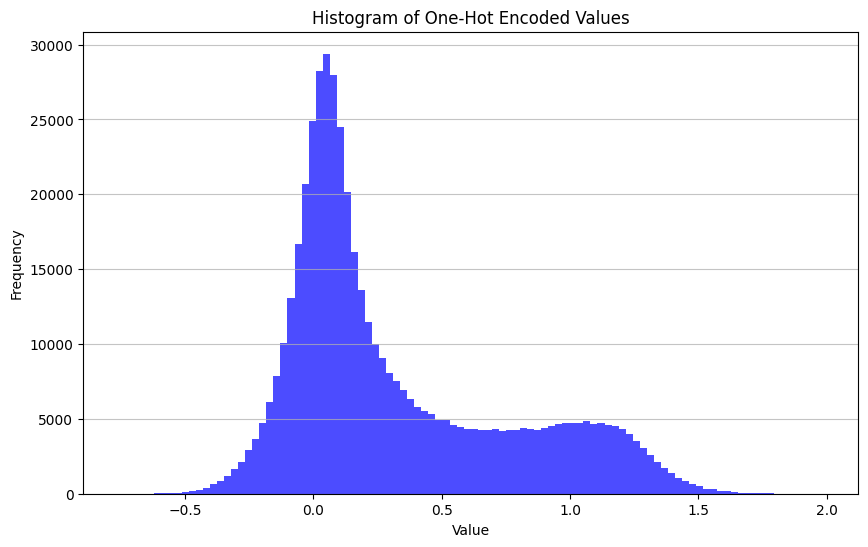

In [37]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(all_one_hots.flatten().cpu(), bins=100, color='blue', alpha=0.7)
plt.title('Histogram of One-Hot Encoded Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
